# Bistable toggle switch model

This notebook implements the bistable toggle switch model. The particularity of it is that the propensities are given as custom functions and that the PMF has a bimodal behavior. 

Imports, set the accuracy to float64 and set the `qtt` flag (`True` if QTT format should be used).

In [1]:
import torch as tn
import torchtt as tntt
import TTCME
import matplotlib.pyplot as plt 
import datetime
import numpy as np

tn.set_default_tensor_type(tn.DoubleTensor)
qtt = True

The particularity of this model is that we provide custom propensities for 2 of the reactions.
In the following, the reactions are defined and the CME generator is constructed.
The state is truncated to `512` per species to allow for the PMF to stay inside the domain as well as for quantization. 

In [2]:
r1 = TTCME.ChemicalReaction(['A', 'B'], '->A', 3000.0, decomposable_propensity=[lambda x: 1.0, lambda x: 1/(11000+x**2)])
r2 = TTCME.ChemicalReaction(['A', 'B'], 'A->', 0.001)
r3 = TTCME.ChemicalReaction(['A', 'B'], '->B', 3000.0, decomposable_propensity=[lambda x: 1/(11000+x**2), lambda x: 1.0])
r4 = TTCME.ChemicalReaction(['A', 'B'], 'B->', 0.001)

mdl = TTCME.ReactionSystem(['A','B'],[r1, r2 ,r3, r4])
N = [512,512]

Att = mdl.generatorTT(N)

Initial condition is implemented:

$$ p(x_1,x_2|t=0) \sim \exp\left(-\frac{1}{2}\left(\frac{(x_1-20)^2}{20}+\frac{(x_2-20)^2}{20}\right)\right)$$

In [3]:
pdf_handle = lambda x: 1/(2*np.pi*20) * tn.exp(-0.5*(x[...,0]-20)**2/20) * tn.exp(-0.5*(x[...,1]-20)**2/20)
pdf_0 = TTCME.pdf.pdfTT.interpoalte(pdf_handle, [TTCME.basis.DiracDeltaBase(n) for n in N], variable_names=['A','B'])

The integrator is instantiated. The time interval is $[0,50000]$ and is divided into 25 equidistant subintervals.
The time discretization method is `'Cheby'`.

In [4]:
fwd_int = TTCME.TimeIntegrator.TTInt(Att if not qtt else Att.to_qtt().round(1e-13), epsilon=1e-5, N_max = 8, dt_max=1000, method='cheby')
pk = pdf_0.dofs.to_qtt() if qtt else pdf_0.dofs.clone()
dT = 2000
Nt = 25

The time integration is performed.

In [5]:
time = 0
for i in range(Nt):
    tme = datetime.datetime.now()
    pk = fwd_int.solve(pk, dT, intervals = 10, qtt = qtt, verb = False, rounding = False)
    pk = pk.round(1e-11) 
    tme = datetime.datetime.now() - tme
    time += dT
    print('Time ', time, ', rank ',pk.R,', solver time ', tme)

pend = pdf_0.copy()
pend.dofs = tntt.reshape(pk, N) if qtt else pk.clone()

Time  2000 , rank  [1, 2, 2, 4, 7, 13, 23, 28, 28, 26, 26, 32, 36, 32, 16, 8, 4, 2, 1] , solver time  0:00:37.602163
Time  4000 , rank  [1, 2, 3, 5, 9, 17, 29, 35, 35, 33, 36, 40, 39, 29, 16, 8, 4, 2, 1] , solver time  0:00:21.687366
Time  6000 , rank  [1, 2, 3, 5, 10, 18, 31, 39, 39, 37, 42, 44, 40, 29, 16, 8, 4, 2, 1] , solver time  0:00:21.145216
Time  8000 , rank  [1, 2, 3, 5, 10, 20, 32, 41, 41, 39, 43, 46, 40, 29, 16, 8, 4, 2, 1] , solver time  0:00:18.388869
Time  10000 , rank  [1, 2, 3, 6, 11, 20, 33, 42, 42, 40, 45, 46, 41, 28, 16, 8, 4, 2, 1] , solver time  0:00:17.755069
Time  12000 , rank  [1, 2, 3, 6, 11, 20, 34, 43, 43, 41, 46, 46, 40, 28, 16, 8, 4, 2, 1] , solver time  0:00:20.875641
Time  14000 , rank  [1, 2, 3, 6, 11, 20, 35, 43, 43, 41, 46, 46, 39, 28, 16, 8, 4, 2, 1] , solver time  0:00:19.709386
Time  16000 , rank  [1, 2, 3, 6, 11, 20, 35, 43, 43, 41, 46, 46, 39, 28, 16, 8, 4, 2, 1] , solver time  0:00:18.050634
Time  18000 , rank  [1, 2, 3, 6, 11, 20, 35, 44, 43, 4

Plot the final solution (as you can see it is bimodal).

Text(0, 0.5, '$x_2$')

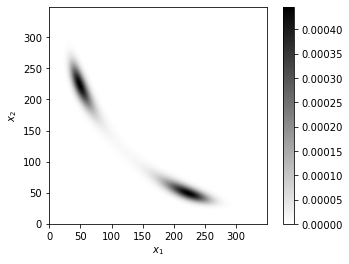

In [7]:
plt.figure()
plt.imshow(pend.dofs.numpy()[:350,:350], origin='lower',cmap='gray_r')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')